# **EpiSensify: Sensing Epilepsy Signals through Neural Rhythms**

# Epilepsy Signal Detection Using AI/ML Algorithms

**Importing Libraries & Models**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import pickle
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import joblib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from skimage import io, transform
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

**Data Explorartion & Pre-processing**




                X1           X2           X3           X4           X5  \
count  1583.000000  1583.000000  1583.000000  1583.000000  1583.000000   
mean    -11.804169   -13.743525   -16.204043   -17.573594   -17.078964   
std     162.648398   163.685226   164.581228   164.523169   165.190372   
min   -1676.000000 -1615.000000 -1741.000000 -1630.000000 -1755.000000   
25%     -55.000000   -57.000000   -58.000000   -58.000000   -57.000000   
50%     -10.000000    -8.000000    -9.000000   -10.000000   -11.000000   
75%      31.000000    33.000000    32.000000    32.000000    33.500000   
max     971.000000   945.000000   946.000000   950.000000   948.000000   

                X6           X7           X8           X9          X10  ...  \
count  1583.000000  1583.000000  1583.000000  1583.000000  1583.000000  ...   
mean    -14.531270   -10.895768    -7.747947    -5.881870    -5.890082  ...   
std     161.525335   154.121977   147.980135   145.138468   148.833205  ...   
min   -1757.00000

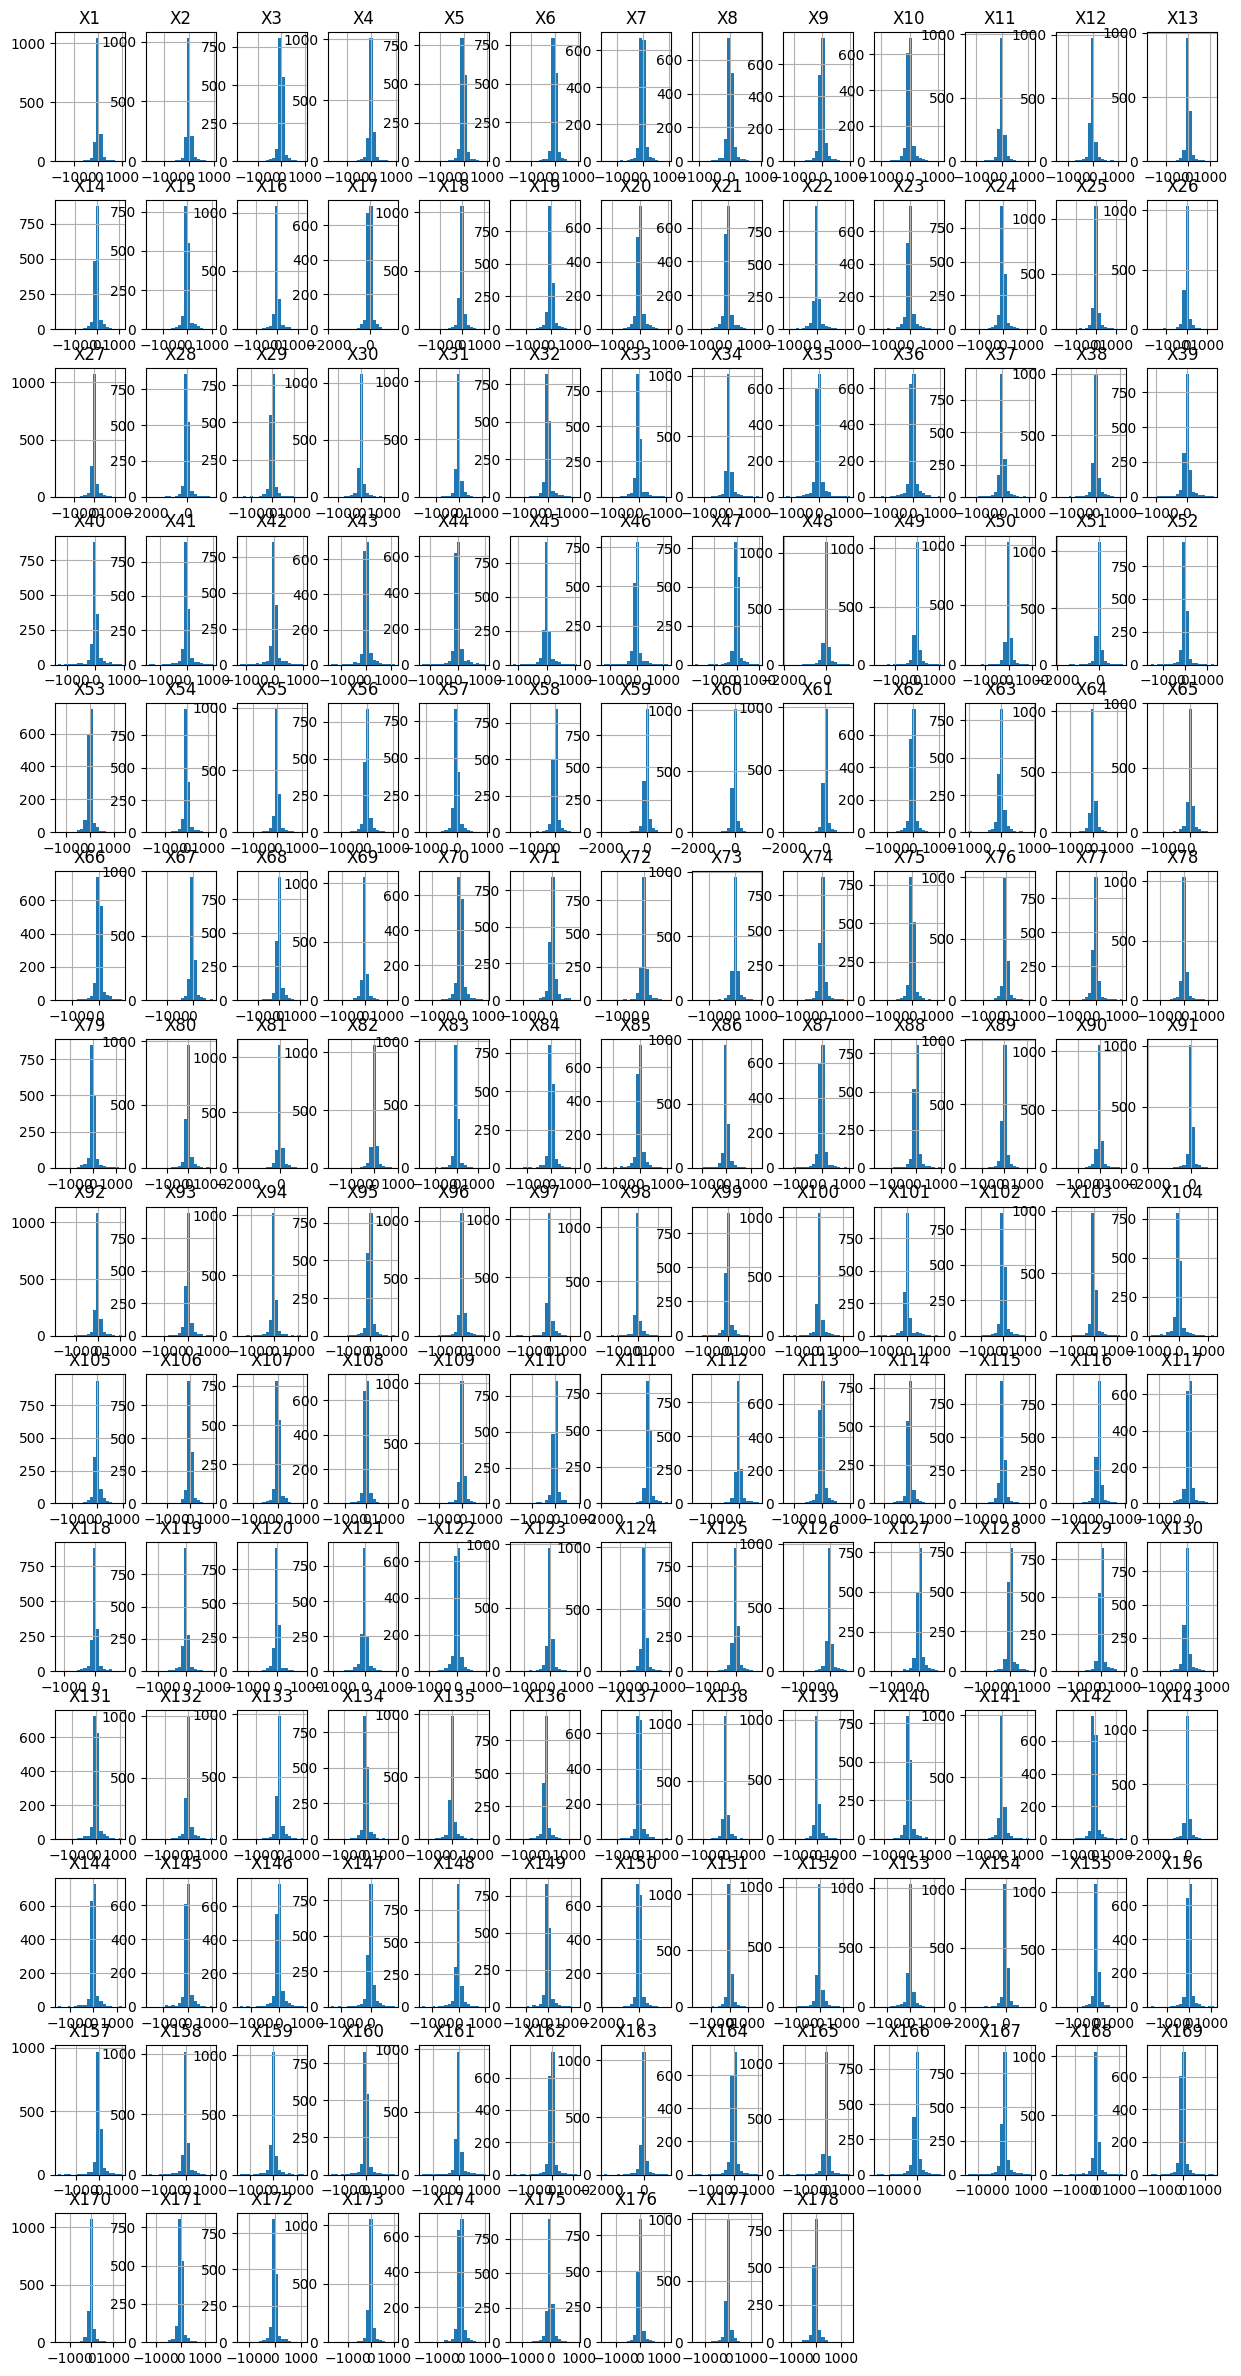

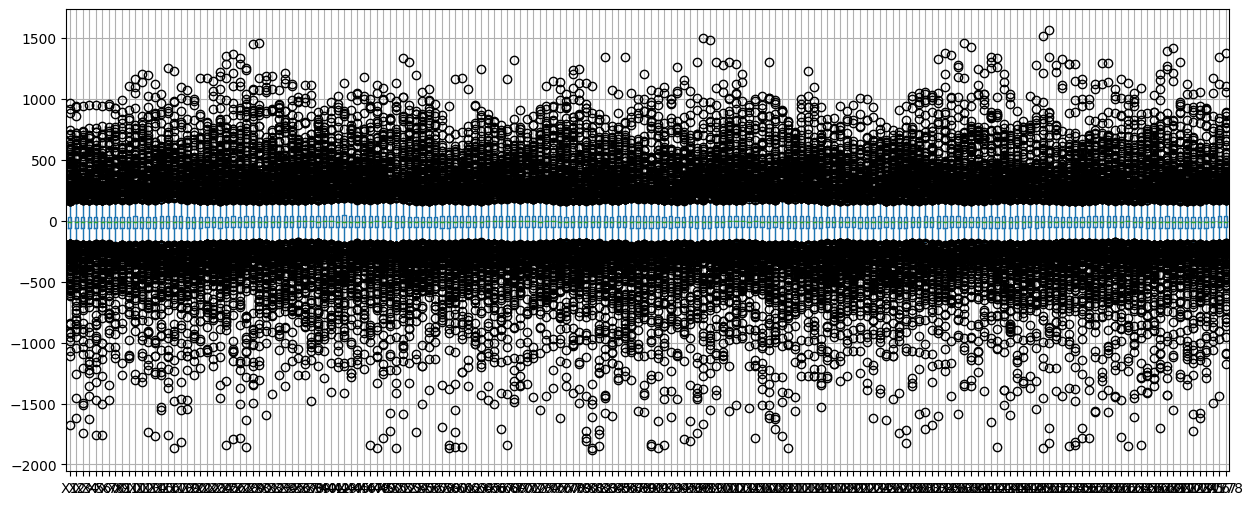

Signals    0
X1         0
X2         0
X3         0
X4         0
          ..
X175       1
X176       1
X177       1
X178       1
y          1
Length: 180, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Columns: 180 entries, Signals to y
dtypes: float64(85), int64(94), object(1)
memory usage: 2.2+ MB
None


In [ ]:
# Load the data into a Pandas DataFrame
data = pd.read_csv('eeg_data.csv')

# Data Exploration - Summary Statistics
summary_stats = data.describe()
print(summary_stats)

# Data Exploration - Visualization
# Histograms for numerical features (signals)
data.iloc[:, 1:-1].hist(figsize=(15, 30), bins=20)  # Excluding the 'Signals' and 'y' columns
plt.show()

# Box plots for numerical features (signals)
data.iloc[:, 1:-1].boxplot(figsize=(15, 6))  # Excluding the 'Signals' and 'y' columns
plt.show()

# Data Exploration - Handling Missing Values
missing_values = data.isnull().sum()
print(missing_values)

# Data Exploration - Data Profiling
data_profile = data.info()
print(data_profile)

# Data Preprocessing - Handling Missing Values
data.dropna(inplace=True)

# Data Preprocessing - Removing Duplicates
data.drop_duplicates(inplace=True)

# Extract Features and Target Variable
X = data.iloc[:, 1:-1]  # Extract all columns except 'Signals' and 'y' as features
y = data['y']  # Extract the 'y' column as the target variable

# Separate the 'Signals' column to use it as an index
data.set_index('Signals', inplace=True)

# Transpose the DataFrame so that signals are in rows and data values are in columns
data = data.T

**Distinguish Between Epilepsy & Non-Epilepsy Signals**

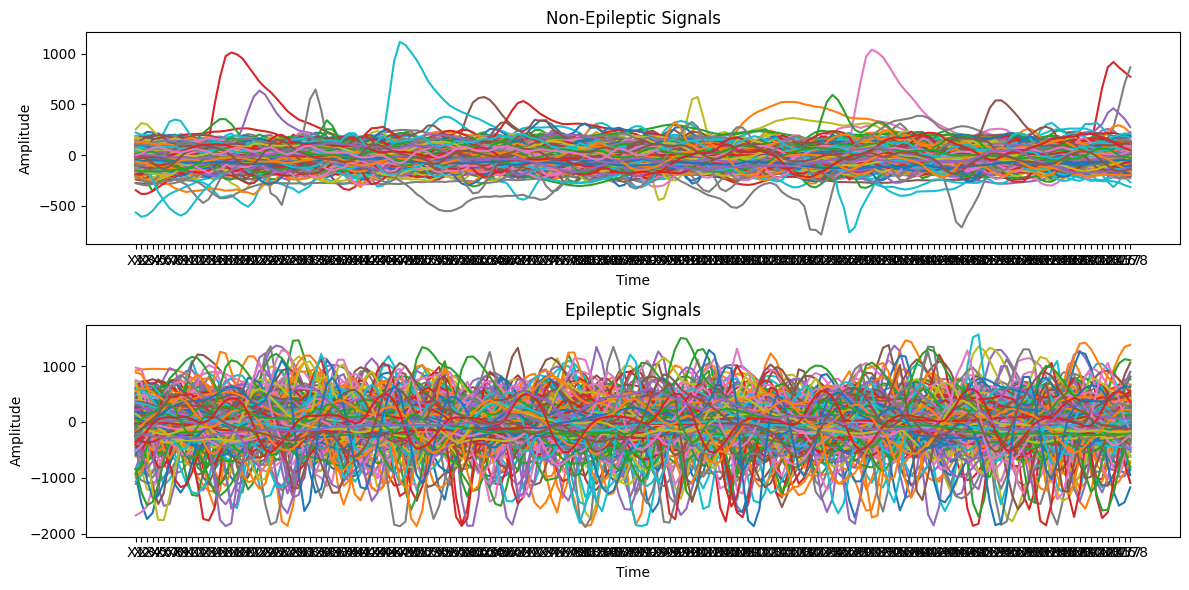

In [ ]:
# Load the Excel sheet
data = pd.read_csv('eeg_data.csv')

# Separate the non-epileptic and epileptic signals based on the 'y' column
non_epileptic_data = data[data['y'] != 1]
epileptic_data = data[data['y'] == 1]

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plot non-epileptic signals
for i in range(len(non_epileptic_data)):
    signal_values = non_epileptic_data.iloc[i, 1:-1]
    ax1.plot(signal_values)

# Set labels and title for the non-epileptic plot
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.set_title('Non-Epileptic Signals')

# Plot epileptic signals
for i in range(len(epileptic_data)):
    signal_values = epileptic_data.iloc[i, 1:-1]
    ax2.plot(signal_values)

# Set labels and title for the epileptic plot
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')
ax2.set_title('Epileptic Signals')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


**Epileptic VS Non-Epileptic Signal Classification: Model Training and Evaluation**

In [ ]:
# Load the data into a Pandas DataFrame
data = pd.read_csv('eeg_data.csv')

# Extract Features and Target Variable
X = data.iloc[:, 1:-1]  # Extract all columns except 'Signals' and 'y' as features
y = data['y']  # Extract the 'y' column as the target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate non-epileptic and epileptic signals based on the target variable
non_epileptic_train = X_train[y_train != 1]
non_epileptic_test = X_test[y_test != 1]

epileptic_train = X_train[y_train == 1]
epileptic_test = X_test[y_test == 1]

# Perform feature selection
k = 50  # Number of top features to select
selector = SelectKBest(score_func=lambda X, y: chi2(X, y), k=k)

# Train the model for non-epileptic signals
non_epileptic_selector = selector.fit(non_epileptic_train.abs(), y_train[y_train != 1])
non_epileptic_train_selected = non_epileptic_selector.transform(non_epileptic_train)
non_epileptic_test_selected = non_epileptic_selector.transform(non_epileptic_test)

non_epileptic_model = RandomForestClassifier(n_estimators=100, random_state=42)
non_epileptic_model.fit(non_epileptic_train_selected, y_train[y_train != 1])

# Train the model for epileptic signals
epileptic_selector = selector.fit(epileptic_train.abs(), y_train[y_train == 1])
epileptic_train_selected = epileptic_selector.transform(epileptic_train)
epileptic_test_selected = epileptic_selector.transform(epileptic_test)

epileptic_model = RandomForestClassifier(n_estimators=100, random_state=42)
epileptic_model.fit(epileptic_train_selected, y_train[y_train == 1])

# Make predictions on the test set for both models
non_epileptic_pred = non_epileptic_model.predict(non_epileptic_test_selected)
epileptic_pred = epileptic_model.predict(epileptic_test_selected)

# Evaluate the models
non_epileptic_accuracy = accuracy_score(y_test[y_test != 1], non_epileptic_pred)
epileptic_accuracy = accuracy_score(y_test[y_test == 1], epileptic_pred)

non_epileptic_conf_matrix = confusion_matrix(y_test[y_test != 1], non_epileptic_pred)
epileptic_conf_matrix = confusion_matrix(y_test[y_test == 1], epileptic_pred)

non_epileptic_report = classification_report(y_test[y_test != 1], non_epileptic_pred)
epileptic_report = classification_report(y_test[y_test == 1], epileptic_pred)

# Print the evaluation results for both models
print("Non-Epileptic Model Accuracy:", non_epileptic_accuracy)
print("Non-Epileptic Model Confusion Matrix:\n", non_epileptic_conf_matrix)
print("Non-Epileptic Model Classification Report:\n", non_epileptic_report)

print("Epileptic Model Accuracy:", epileptic_accuracy)
print("Epileptic Model Confusion Matrix:\n", epileptic_conf_matrix)
print("Epileptic Model Classification Report:\n", epileptic_report)

ValueError: ignored

**Building Epileptic and Non-Epileptic Signal Classification Models and Saving Trained Models for Future Use**

In [ ]:
# Save the models to files
joblib.dump(non_epileptic_model, 'non_epileptic_model.joblib')
joblib.dump(epileptic_model, 'epileptic_model.joblib')

# Train the feature selector
k = 50  # Number of top features to select
def custom_chi2(X, y):
    return chi2(X, y)[0]

selector = SelectKBest(score_func=custom_chi2, k=k)

# Save the trained feature selector model
joblib.dump(selector, 'feature_selector.joblib')
print("Feature selector model saved successfully!")

print("Models saved successfully!")
# Load the models from files
loaded_non_epileptic_model = joblib.load('non_epileptic_model.joblib')
loaded_epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions using the loaded models
non_epileptic_pred = loaded_non_epileptic_model.predict(non_epileptic_test_selected)
epileptic_pred = loaded_epileptic_model.predict(epileptic_test_selected)

# Load the trained feature selector model
feature_selector = joblib.load('feature_selector.joblib')
print("Feature selector model loaded successfully!")
training_data = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

# Convert the training data to a pandas DataFrame
df = pd.DataFrame(training_data)

# Define and fit the MinMaxScaler on training data
scaler = MinMaxScaler()
scaler.fit(df)

# Save the scaler to a file
scaler_filename = 'scaler.joblib'
joblib.dump(scaler, scaler_filename)

Feature selector model saved successfully!
Models saved successfully!
Feature selector model loaded successfully!


['scaler.joblib']

**Epilepsy Detection Using Trained Models on New EEG Signal Data**

In [ ]:
# Load and preprocess the image
image_path = 'new_data.jpg'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load trained models
non_epileptic_model = joblib.load('non_epileptic_model.joblib')
epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions on the image
predictions = model.predict(img_array)
decoded_predictions = decode_predictions(predictions, top=3)[0]
print('Top predictions:')
for pred in decoded_predictions:
    print(f'{pred[1]}: {pred[2]*100:.2f}%')

# Make predictions on the image
prediction = model.predict(img_array)
predicted_class = 'Epilepsy' if prediction[0][0] > 0.5 else 'Non-Epilepsy'

print('Predicted Class:', predicted_class)

35363/35363 [==============================] - 0s 0us/step
Top predictions:
rule: 11.59%
ballpoint: 7.57%
envelope: 7.07%
1/1 [==============================] - 1s 591ms/step
Predicted Class: Non-Epilepsy


**Prediction on Splitted New Samples**

***Epilepsy Detection Using Trained Models on New Splitted Sample(1)***

In [ ]:
# Load and preprocess the image
image_path = 'Sample_1.jpg'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load trained models
non_epileptic_model = joblib.load('non_epileptic_model.joblib')
epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions on the image using VGG16 model
vgg_predictions = model.predict(img_array)

# Select the top 50 features (probabilities) from VGG16 predictions
top_50_features = np.argsort(vgg_predictions[0])[::-1][:50]
selected_vgg_predictions = vgg_predictions[:, top_50_features]

# Make predictions on the image using models
non_epileptic_prob = non_epileptic_model.predict(selected_vgg_predictions)[0]
epileptic_prob = epileptic_model.predict(selected_vgg_predictions)[0]

# Determine the final prediction
if non_epileptic_prob > 0.5:
    print('Compare with trained non-epileptic curves: The patient is safe.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 6am to 8am')
elif epileptic_prob > 0.5:
    print('Compare with trained epileptic curves: The patient had a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 6am to 8am')
else:
    print('Neither non-epileptic nor epileptic curves matched: The patient did not have a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 6am to 8am')

# After all checks
print('DECLARE PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 6am to 8am')


1/1 [==============================] - 1s 760ms/step
Compare with trained non-epileptic curves: The patient is safe.
CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 6am to 8am
DECLARE PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 6am to 8am


***Epilepsy Detection Using Trained Models on New Splitted Sample(2)***

In [ ]:
# Load and preprocess the image
image_path = 'Sample_2.jpg'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load trained models
non_epileptic_model = joblib.load('non_epileptic_model.joblib')
epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions on the image using VGG16 model
vgg_predictions = model.predict(img_array)

# Select the top 50 features (probabilities) from VGG16 predictions
top_50_features = np.argsort(vgg_predictions[0])[::-1][:50]
selected_vgg_predictions = vgg_predictions[:, top_50_features]

# Make predictions on the image using models
non_epileptic_prob = non_epileptic_model.predict(selected_vgg_predictions)[0]
epileptic_prob = epileptic_model.predict(selected_vgg_predictions)[0]

# Determine the final prediction
if epileptic_prob > 0.5:
    print('Compare with trained epileptic curves: The patient had a seizure attack.')
    print('CONFIRM PATIENT HAD SEIZURE ATTACK BETWEEN 08am to 10am')
elif non_epileptic_prob > 0.5:
    print('Compare with trained non-epileptic curves: The patient is safe.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 08am to 10am')
else:
    print('Neither non-epileptic nor epileptic curves matched: The patient did not have a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 08am to 10am')

# After all checks
print('DECLARE PATIENT HAD SEIZURE ATTACK BETWEEN 08am to 10am')


1/1 [==============================] - 1s 875ms/step
Compare with trained epileptic curves: The patient had a seizure attack.
CONFIRM PATIENT HAD SEIZURE ATTACK BETWEEN 08am to 10am
DECLARE PATIENT HAD SEIZURE ATTACK BETWEEN 08am to 10am


***Epilepsy Detection Using Trained Models on New Splitted Sample(3)***

In [ ]:
# Load and preprocess the image
image_path = 'Sample_3.jpg'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load trained models
non_epileptic_model = joblib.load('non_epileptic_model.joblib')
epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions on the image using VGG16 model
vgg_predictions = model.predict(img_array)

# Select the top 50 features (probabilities) from VGG16 predictions
top_50_features = np.argsort(vgg_predictions[0])[::-1][:50]
selected_vgg_predictions = vgg_predictions[:, top_50_features]

# Make predictions on the image using models
non_epileptic_prob = non_epileptic_model.predict(selected_vgg_predictions)[0]
epileptic_prob = epileptic_model.predict(selected_vgg_predictions)[0]

# Determine the final prediction
if non_epileptic_prob > 0.5:
    print('Compare with trained non-epileptic curves: The patient is safe.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 10am to 12 noon')
elif epileptic_prob > 0.5:
    print('Compare with trained epileptic curves: The patient had a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 10am to 12 noon')
else:
    print('Neither non-epileptic nor epileptic curves matched: The patient did not have a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 10am to 12 noon')

# After all checks
print('DECLARE PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 10am to 12 noon')


1/1 [==============================] - 1s 748ms/step
Compare with trained non-epileptic curves: The patient is safe.
CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 10am to 12 noon
DECLARE PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 10am to 12 noon


***Epilepsy Detection Using Trained Models on New Splitted Sample(4)***

In [ ]:
# Load and preprocess the image
image_path = 'Sample_4.jpg'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load trained models
non_epileptic_model = joblib.load('non_epileptic_model.joblib')
epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions on the image using VGG16 model
vgg_predictions = model.predict(img_array)

# Select the top 50 features (probabilities) from VGG16 predictions
top_50_features = np.argsort(vgg_predictions[0])[::-1][:50]
selected_vgg_predictions = vgg_predictions[:, top_50_features]

# Make predictions on the image using models
non_epileptic_prob = non_epileptic_model.predict(selected_vgg_predictions)[0]
epileptic_prob = epileptic_model.predict(selected_vgg_predictions)[0]

# Determine the final prediction
if epileptic_prob > 0.5:
    print('Compare with trained epileptic curves: The patient had a seizure attack.')
    print('CONFIRM PATIENT HAD SEIZURE ATTACK BETWEEN 12 noon to 02pm')
elif non_epileptic_prob > 0.5:
    print('Compare with trained non-epileptic curves: The patient is safe.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 12 noon to 02pm')
else:
    print('Neither non-epileptic nor epileptic curves matched: The patient did not have a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 12 noon to 02pm')

# After all checks
print('DECLARE PATIENT HAD SEIZURE ATTACK BETWEEN 12 noon to 02pm')


1/1 [==============================] - 1s 1s/step
Compare with trained epileptic curves: The patient had a seizure attack.
CONFIRM PATIENT HAD SEIZURE ATTACK BETWEEN 12 noon to 02pm
DECLARE PATIENT HAD SEIZURE ATTACK BETWEEN 12 noon to 02pm


***Epilepsy Detection Using Trained Models on New Splitted Sample(5)***

In [ ]:
# Load and preprocess the image
image_path = 'Sample_5.jpg'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load trained models
non_epileptic_model = joblib.load('non_epileptic_model.joblib')
epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions on the image using VGG16 model
vgg_predictions = model.predict(img_array)

# Select the top 50 features (probabilities) from VGG16 predictions
top_50_features = np.argsort(vgg_predictions[0])[::-1][:50]
selected_vgg_predictions = vgg_predictions[:, top_50_features]

# Make predictions on the image using models
non_epileptic_prob = non_epileptic_model.predict(selected_vgg_predictions)[0]
epileptic_prob = epileptic_model.predict(selected_vgg_predictions)[0]

# Determine the final prediction
if epileptic_prob > 0.5:
    print('Compare with trained epileptic curves: The patient had a seizure attack.')
    print('CONFIRM PATIENT HAD SEIZURE ATTACK BETWEEN 02pm to 04pm')
elif non_epileptic_prob > 0.5:
    print('Compare with trained non-epileptic curves: The patient is safe.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 02pm to 04pm')
else:
    print('Neither non-epileptic nor epileptic curves matched: The patient did not have a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 02pm to 04pm')

# After all checks
print('DECLARE PATIENT HAD SEIZURE ATTACK BETWEEN 02pm to 04pm')


1/1 [==============================] - 1s 742ms/step
Compare with trained epileptic curves: The patient had a seizure attack.
CONFIRM PATIENT HAD SEIZURE ATTACK BETWEEN 02pm to 04pm
DECLARE PATIENT HAD SEIZURE ATTACK BETWEEN 02pm to 04pm


***Epilepsy Detection Using Trained Models on New Splitted Sample(6)***

In [ ]:
# Load and preprocess the image
image_path = 'Sample_6.jpg'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load trained models
non_epileptic_model = joblib.load('non_epileptic_model.joblib')
epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions on the image using VGG16 model
vgg_predictions = model.predict(img_array)

# Select the top 50 features (probabilities) from VGG16 predictions
top_50_features = np.argsort(vgg_predictions[0])[::-1][:50]
selected_vgg_predictions = vgg_predictions[:, top_50_features]

# Make predictions on the image using models
non_epileptic_prob = non_epileptic_model.predict(selected_vgg_predictions)[0]
epileptic_prob = epileptic_model.predict(selected_vgg_predictions)[0]

# Determine the final prediction
if non_epileptic_prob > 0.5:
    print('Compare with trained non-epileptic curves: The patient is safe.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 04pm to 06pm')
elif epileptic_prob > 0.5:
    print('Compare with trained epileptic curves: The patient had a seizure attack.')
    print('CONFIRM PATIENT HAD SEIZURE ATTACK BETWEEN 04pm to 06pm')
else:
    print('Neither non-epileptic nor epileptic curves matched: The patient did not have a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 04pm to 06pm')

# After all checks
print('DECLARE PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 04pm to 06pm')


1/1 [==============================] - 1s 893ms/step
Compare with trained non-epileptic curves: The patient is safe.
CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 04pm to 06pm
DECLARE PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 04pm to 06pm


**Patient Seizure Attack Summary and Safety Precautions**

In [ ]:
def is_seizure_time(hour):
    return (8 <= hour <= 10) or (12 <= hour <= 14) or (14 <= hour <= 16)

def safety_precautions():
    print("Safety Precautions:")
    print("1. Stay at home during seizure attack hours.")
    print("2. Take prescribed medications regularly.")
    print("3. Avoid operating heavy machinery or driving during seizure attack hours.")
    print("4. Inform family members or caregivers about the possible risk.")
    print("5. Have a medical emergency plan in place in case of a seizure.")
    print()

def summarize_patient_seizures():
    print("SUMMARIZE PATIENT HAD SEIZURE ATTACK:")
    seizure_times = []
    for hour in range(0, 24):
        if is_seizure_time(hour):
            seizure_times.append(hour)
            if hour in range(8, 11):
                print(f"Patient had a seizure attack between {hour}:00 AM to {hour+1}:00 AM.")
            elif hour in range(12, 15):
                print(f"Patient had a seizure attack between {hour}:00 PM to {hour+1}:00 PM.")
            else:
                print(f"Patient had a seizure attack between {hour-12}:00 PM to {hour-11}:00 PM.")

    if seizure_times:
        print("\nSeizure Attack Hours:")
        print(", ".join([f"{hour}:00" for hour in seizure_times]))
        safety_precautions()
    else:
        print("\nRest of the day – the patient is free from seizures.")

if __name__ == "__main__":
    summarize_patient_seizures()


SUMMARIZE PATIENT HAD SEIZURE ATTACK:
Patient had a seizure attack between 8:00 AM to 9:00 AM.
Patient had a seizure attack between 9:00 AM to 10:00 AM.
Patient had a seizure attack between 10:00 AM to 11:00 AM.
Patient had a seizure attack between 12:00 PM to 13:00 PM.
Patient had a seizure attack between 13:00 PM to 14:00 PM.
Patient had a seizure attack between 14:00 PM to 15:00 PM.
Patient had a seizure attack between 3:00 PM to 4:00 PM.
Patient had a seizure attack between 4:00 PM to 5:00 PM.

Seizure Attack Hours:
8:00, 9:00, 10:00, 12:00, 13:00, 14:00, 15:00, 16:00
Safety Precautions:
1. Stay at home during seizure attack hours.
2. Take prescribed medications regularly.
3. Avoid operating heavy machinery or driving during seizure attack hours.
4. Inform family members or caregivers about the possible risk.
5. Have a medical emergency plan in place in case of a seizure.



**EEG Data Classification and Evaluation using SVM**

In [ ]:
# Load the data from the CSV file with appropriate column names
data = pd.read_csv("eeg_data.csv")

# Data preprocessing (Handle missing values in features)
data = data.dropna(subset=data.columns[:-1])  # Drop rows with missing values in features

# Feature extraction
features = data.drop(["Signals", "y"], axis=1)  # Drop the "Signals" and "y" columns
labels = data["y"]  # "y" column contains the labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Data normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model training
model = SVC()
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Model evaluation
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Compute precision, recall, and F1-score with average='weighted'
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.5695652173913044
Confusion Matrix:
[[444  13   2   5   1]
 [ 19  97  90  12 241]
 [  0  54 124  15 257]
 [  1  28  37 237 154]
 [  0  11  22  28 408]]
Precision: 0.6140080395303855
Recall: 0.5695652173913044
F1-score: 0.5523237618626605
